<a href="https://colab.research.google.com/github/Mobad225/Topolgy-Mapping/blob/master/Topology_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload Dataset

In [0]:
from google.colab import files
files.upload();

Saving dataset.zip to dataset.zip


In [0]:
!unzip -q dataset.zip

In [0]:
import numpy as np

# Function to read the topologies

In [0]:
def read_data (size):
  topology = np.zeros((10 , size ,size))
  for i in range(10):
    path = 't_'+str(size)+'_'+str(i)+'.txt'
    with open('/content/Dataset/'+path) as f:
     for line in f: 
      from_node , to_node , weight = ([int(x) for x in line.split()])
      topology[i][from_node-1][to_node-1] += weight
      topology[i][to_node-1][from_node-1] += weight
  return topology

# Function to read the ground truth

In [0]:
def read_truth():
  path = '/content/Dataset/ground_truth.txt'
  ret_10, ret_50 = [], []
  with open(path) as doc:
    for i,line in enumerate(doc):
      line_list = list(map(int, line.split()))
      if i < 10:
        ret_10.append(line_list)
      else:
        ret_50.append(line_list)
  ret_10 = np.reshape(np.array(ret_10), (10, 10))
  ret_50 = np.reshape(np.array(ret_50), (10, 50))
  return ret_10, ret_50

# Reading the topologies

In [0]:
topology_10 = read_data(10).astype(int)
topology_50 = read_data(50).astype(int)
topology_100 = read_data(100).astype(int)

# Reading the ground truth

In [0]:
truth_10, truth_50 = read_truth()

# Function to print a graph of a topology

In [0]:
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(topology, col = None, title = None):
  G = nx.from_numpy_matrix(np.matrix(topology), create_using=nx.Graph)
  plt.figure(figsize = (12, 9))
  ax = plt.gca()
  ax.axis('off')
  layout = nx.circular_layout(G)
  labels = nx.get_edge_attributes(G, "weight")
  nodes = {x : x + 1 for x in range(topology.shape[0])}
  nx.draw_networkx(G, pos = layout, with_labels = False)
  nx.draw_networkx_edge_labels(G, pos = layout, edge_labels= labels);
  nx.draw_networkx_labels(G, layout, nodes, font_size= 12)
  nx.draw_networkx_nodes(G, pos = layout, node_color = col)
  plt.title(title)
  plt.show()
  print('==========================================================='.center(85))
  plt.close()

# Visualizing the topologies

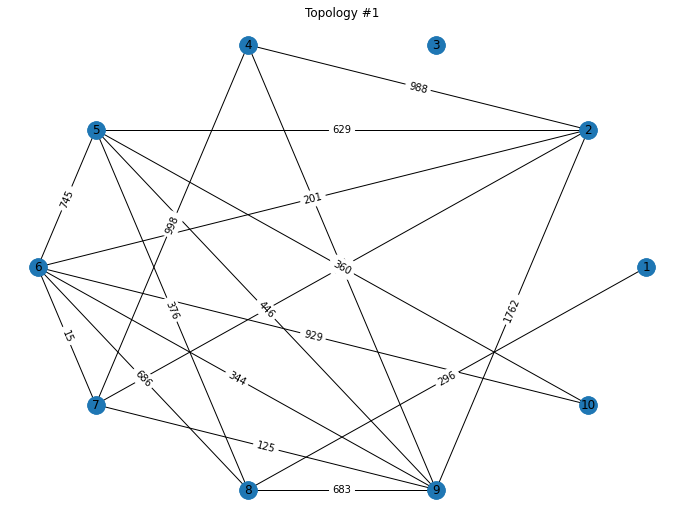

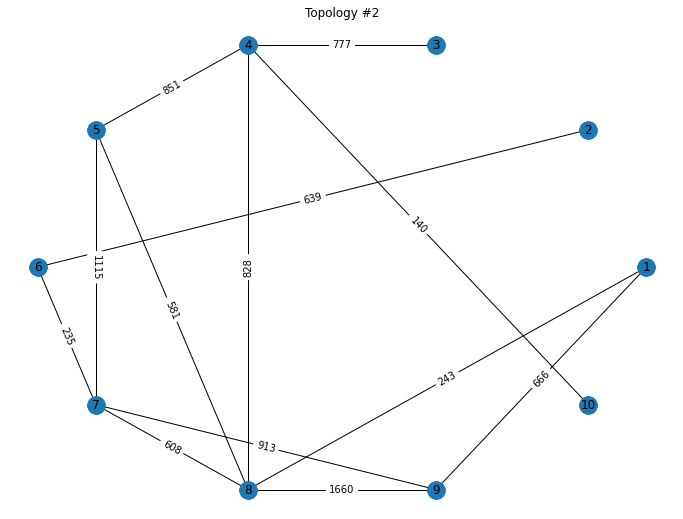

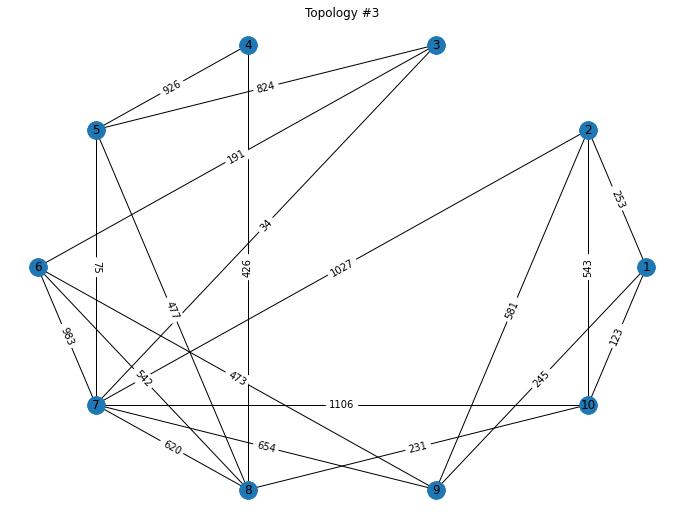

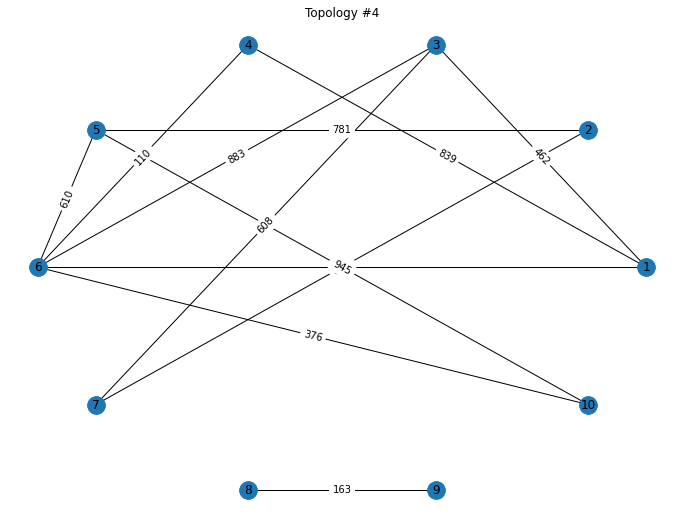

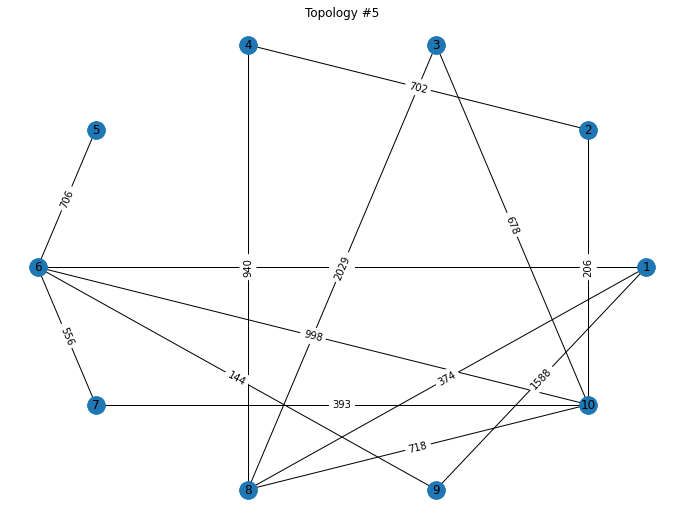

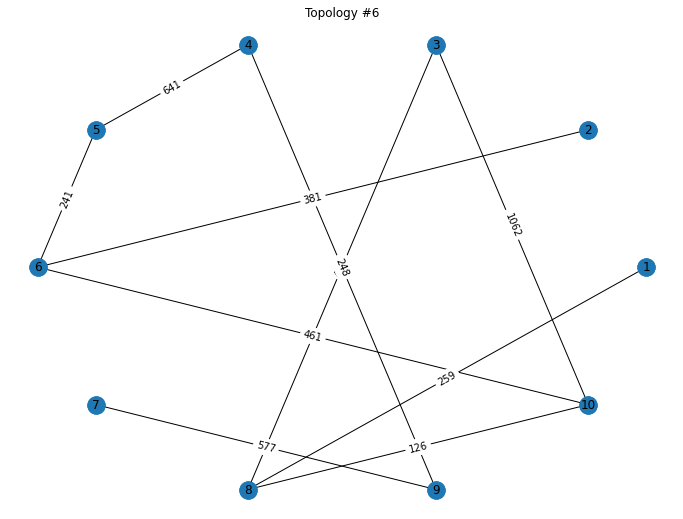

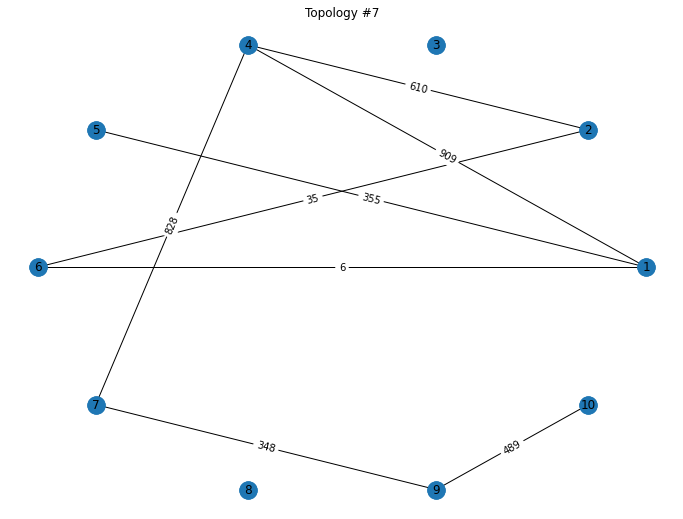

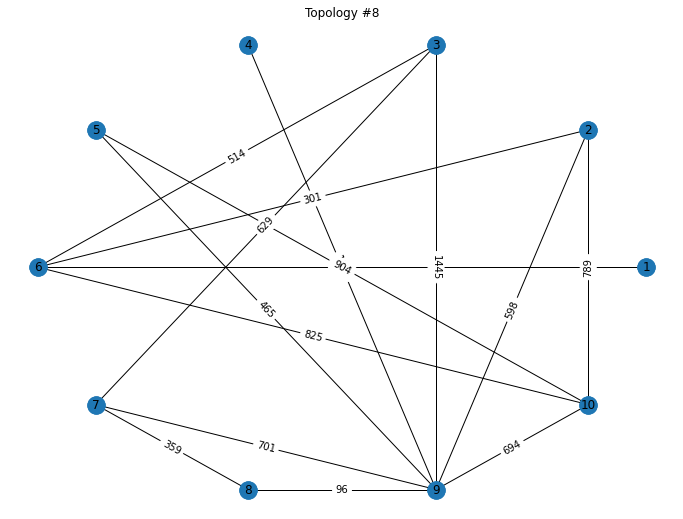

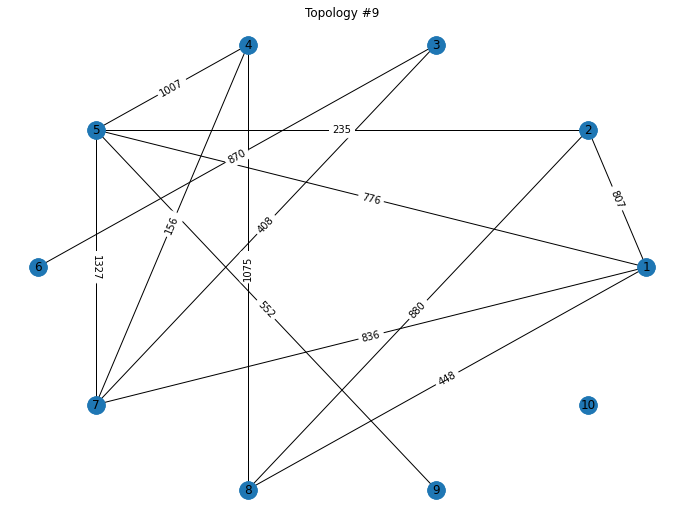

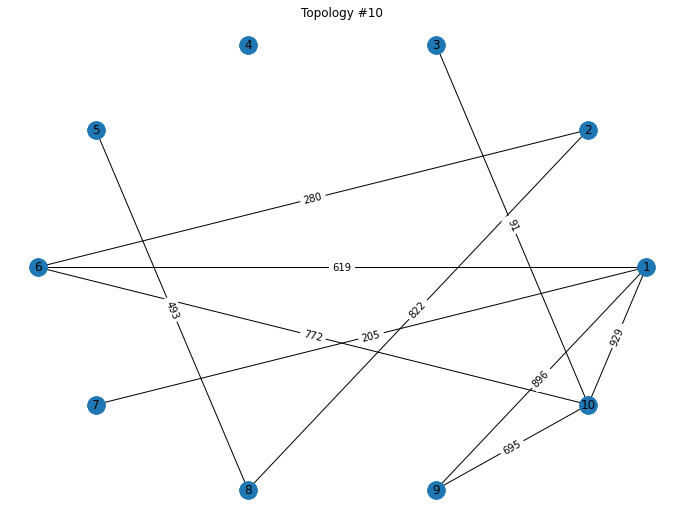

In [98]:
for i in range(10):
  draw_graph(topology_10[i], title = 'Topology #{}'.format(i + 1))

# Topology Mapping

### Function to spectral cluster a topology

In [0]:
from sklearn import preprocessing
from sklearn.cluster import KMeans

def spectral_cluster(adj, k = [2]):
  D = np.diag(adj.sum(axis = 1))
  L = D - adj
  D_inv = np.linalg.pinv(D)
  La = D_inv.dot(L)
  Eigenvalues, Eigenvectors = np.linalg.eig(La)
  idx = Eigenvalues.argsort()
  Eigenvalues = Eigenvalues[idx]
  Eigenvectors = Eigenvectors[:,idx]
  ret = []
  true = truth_10[1] ##############
  for k_curr in k:
    W = Eigenvectors[:, :k_curr]
    kmeans = KMeans(n_clusters = k_curr, random_state = 0).fit(W)
    pred = kmeans.labels_
    #print(f_measure(true, pred, k_curr))
    #print(conditional_entropy(true, pred, k_curr))
    ret.append(pred)
  return np.reshape(np.array(ret), (len(k), len(adj)))

# Internal Evaluation Methods

## F-Measure Function

In [0]:
def f_measure(true_data , pred_data , k):
  k_true = np.amax(true_data)+1
  clusters = np.zeros((k,k_true))
  for i in range(pred_data.size):
    clusters[pred_data[i]][true_data[i]] += 1
  fmeasure_sum = 0.0
  for cluster in clusters:  
    max_index = np.argmax(cluster) 
    total = np.sum(cluster) 
    purity = cluster[max_index]/total
    recall = cluster[max_index]/np.sum(clusters[:,max_index], axis = 0)
    fmeasure_sum += (2 * purity * recall) / (purity + recall)
  return fmeasure_sum/k

## Conditional Entropy Function

In [0]:
import math

def conditional_entropy(true_data , pred_data , k):
  k_true = np.amax(true_data) + 1
  clusters = np.zeros((k, k_true))
  for i in range(pred_data.size):
    clusters[pred_data[i]][true_data[i]] += 1
  entropy_sum = 0.0
  for cluster in clusters:   
    total = np.sum(cluster)
    curr = np.sum(np.array([((x/total)*math.log(x/total, 2)) for x in cluster if x != 0]))
    entropy_sum += (-curr) * total/len(true_data)
  return entropy_sum

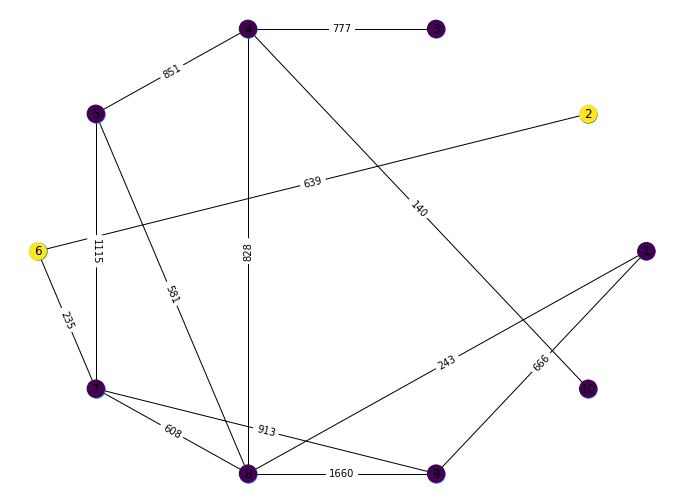

In [102]:
#############################################
k = [2]
labels = spectral_cluster(topology_10[1], k = k)
for i in range(len(k)):
  draw_graph(topology_10[1], col = labels[i])

# Internal Evaluation Methods

## Normalized Cut Functions

In [0]:
def pre_ncut(topology):
  dist_matrix = np.zeros((topology.shape[0],topology.shape[1]))
  for i in range(topology.shape[0]):
    for j in range(i, topology.shape[1]):
      dist_matrix[i][j] = math.exp(-0.01*max(topology[i][j],1))
      dist_matrix[j][i] = math.exp(-0.01*max(topology[i][j],1))
  degree_matrix = np.diag(dist_matrix.sum(axis = 1))
  return dist_matrix, degree_matrix

In [0]:
def W(labels, ind, dist, deg):
  mask = np.multiply(np.array(labels == ind), 1)
  internal = mask.dot(dist.dot(mask.T))
  external = mask.dot(deg.dot(mask.T)) - internal
  return internal, external

def n_cut(topology, labels, k):
  dist_matrix, deg_matrix = pre_ncut(topology)
  tot = 0
  for i in range(k):
    internal, external = W(labels, i, dist_matrix, deg_matrix)
    tot += external /(internal + external)
  return tot